In [1]:
# number of CPUs to be used
NCPU=20

## Load and process the dataset

In [2]:
import gzip, json
import numpy as np
import utils 
from sklearn.model_selection import train_test_split

# 20 standard amino acids
aa2idx = {'A':0, 'R':1, 'N':2, 'D':3, 'C':4, 'Q':5, 'E':6, 'G':7, 'H':8, 'I':9,
          'L':10, 'K':11, 'M':12, 'F':13, 'P':14, 'S':15, 'T':16, 'W':17, 'Y':18, 'V':19}

# load
dataset = utils.load_phipsi()

# 90% train, 10% test
train,test = train_test_split(dataset, test_size=0.1, random_state=42)


## Randomness in clustering

K-means clustering is not guarantied to converge to the best  global solution each time you run it, but rather gives you a local suboptimal splitting. To check how this randomness in the k-means clusters affects the full angle prediction pipeline, we repeat clustering-training-testing procedure multiple times (number of clusters is fixed to 15) and compare the results.

In [3]:
WINDOW = 15

# do not need to change X (1-hot-encoded sequence)
# so can set it only once
X_train = utils.getX(train, WINDOW)
X_test = utils.getX(test, WINDOW)

# reference phi,psi for the test set
# also do not change
phi_ref = utils.getPHI(test, WINDOW)
psi_ref = utils.getPSI(test, WINDOW)


In [4]:
%%time
from sklearn.cluster import KMeans
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss

WINDOW = 15

# number of times clustering-learning-testing pipeline
# will be repeated
niter = 10

# will save all clustering results here
KMEANS = []
scores = []

for i in range(niter):
    
    # cluster
    KM = KMeans(n_clusters=20, max_iter=5, n_jobs=NCPU)
    KM.fit(np.vstack([item['avec'] for item in train]))
    
    # save current solution
    KMEANS.append(KM)
    
    # update Y vectors (cluster IDs for central residues)
    Y_train = utils.getY(train, WINDOW, KM)
    Y_test = utils.getY(test, WINDOW, KM)
    
    # train logistis regression model
    sgd = SGDClassifier(max_iter=10, tol=1e-3, loss='log', n_jobs=NCPU)
    sgd.fit(X_train, Y_train)
    
    # calculate sin(.),cos(.) weighted averages on the test set
    avec = np.matmul(sgd.predict_proba(X_test), KM.cluster_centers_)

    # convert angle vectors to true angles
    norm_phi = np.sqrt(np.square(avec[:,0])+np.square(avec[:,1]))
    norm_psi = np.sqrt(np.square(avec[:,2])+np.square(avec[:,3]))
    phi_pred = np.arctan2(avec[:,0] / norm_phi, avec[:,1] / norm_phi)
    psi_pred = np.arctan2(avec[:,2] / norm_psi, avec[:,3] / norm_psi)

    #score_train = sgd.score(X_train, Y_train)
    #score_test = sgd.score(X_test, Y_test)

    # calculate scores
    loss = log_loss(Y_test, sgd.predict_proba(X_test))
    rmse_phi = utils.ang_rmse(phi_ref, phi_pred) * 180 / np.pi
    rmse_psi = utils.ang_rmse(psi_ref, psi_pred) * 180 / np.pi
    
    scores.append([rmse_phi, rmse_psi, loss])
    
    print("iter {:2d} | loss {:.5f} | rmse(phi) {:9.5f} | rmse(phi) {:9.5f}".
          format(i, loss, rmse_phi, rmse_psi))

iter  0 | loss 2.26217 | rmse(phi)  44.13238 | rmse(phi)  87.12407
iter  1 | loss 2.28058 | rmse(phi)  43.88721 | rmse(phi)  87.42620
iter  2 | loss 2.14037 | rmse(phi)  44.41584 | rmse(phi)  87.46787
iter  3 | loss 2.27484 | rmse(phi)  44.08084 | rmse(phi)  87.50725
iter  4 | loss 2.22378 | rmse(phi)  44.35955 | rmse(phi)  87.11227


KeyboardInterrupt: 

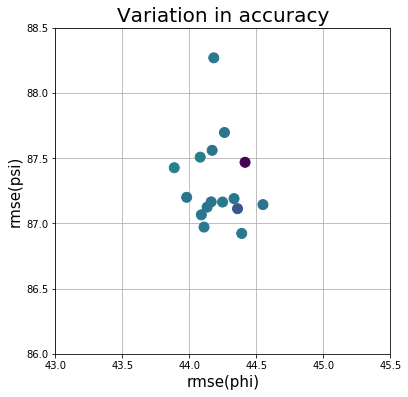

In [11]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

xyc = np.array(scores)

plt.figure(figsize=(6,6))
plt.xlim([43,45.5])
plt.ylim([86,88.5])
plt.xlabel('rmse(phi)', fontsize=15)
plt.ylabel('rmse(psi)', fontsize=15)
plt.grid()
plt.rc('axes', axisbelow=True)
plt.title('Variation in accuracy', fontsize=20)
plt.scatter(xyc[:,0], xyc[:,1], c=xyc[:,2], s=100)
plt.show()

## Effect of window size

In [10]:
# select the first cluster
KM = KMEANS[0]

scores = []

for WINDOW in range(1,32,2):
    
    # WINDOW changes, so does X
    X_train = utils.getX(train, WINDOW)
    X_test = utils.getX(test, WINDOW)
    
    # update Y vectors (cluster IDs for central residues)
    Y_train = utils.getY(train, WINDOW, KM)
    Y_test = utils.getY(test, WINDOW, KM)
    
    # same for reference angles
    phi_ref = utils.getPHI(test, WINDOW)
    psi_ref = utils.getPSI(test, WINDOW)

    # train logistis regression model
    sgd = SGDClassifier(max_iter=10, tol=1e-3, loss='log', n_jobs=NCPU)
    sgd.fit(X_train, Y_train)
    
    # calculate sin(.),cos(.) weighted averages on the test set
    avec = np.matmul(sgd.predict_proba(X_test), KM.cluster_centers_)

    # convert angle vectors to true angles
    norm_phi = np.sqrt(np.square(avec[:,0])+np.square(avec[:,1]))
    norm_psi = np.sqrt(np.square(avec[:,2])+np.square(avec[:,3]))
    phi_pred = np.arctan2(avec[:,0] / norm_phi, avec[:,1] / norm_phi)
    psi_pred = np.arctan2(avec[:,2] / norm_psi, avec[:,3] / norm_psi)

    #score_train = sgd.score(X_train, Y_train)
    #score_test = sgd.score(X_test, Y_test)

    # calculate scores
    loss = log_loss(Y_test, sgd.predict_proba(X_test))
    rmse_phi = utils.ang_rmse(phi_ref, phi_pred) * 180 / np.pi
    rmse_psi = utils.ang_rmse(psi_ref, psi_pred) * 180 / np.pi
    
    scores.append([WINDOW, rmse_phi, rmse_psi, loss])
    
    print("WINDOW {:2d} | loss {:.5f} | rmse(phi) {:9.5f} | rmse(phi) {:9.5f}".
          format(WINDOW, loss, rmse_phi, rmse_psi))

WINDOW  1 | loss 2.45558 | rmse(phi)  45.08567 | rmse(phi)  94.33908
WINDOW  3 | loss 2.35591 | rmse(phi)  44.87640 | rmse(phi)  92.26223
WINDOW  5 | loss 2.31479 | rmse(phi)  44.54438 | rmse(phi)  90.54996
WINDOW  7 | loss 2.28949 | rmse(phi)  44.88143 | rmse(phi)  89.29376
WINDOW  9 | loss 2.27605 | rmse(phi)  44.17605 | rmse(phi)  88.74192
WINDOW 11 | loss 2.26905 | rmse(phi)  44.18231 | rmse(phi)  88.26850
WINDOW 13 | loss 2.26429 | rmse(phi)  44.26200 | rmse(phi)  87.69624
WINDOW 15 | loss 2.26232 | rmse(phi)  44.17010 | rmse(phi)  87.55962
WINDOW 17 | loss 2.26173 | rmse(phi)  44.16269 | rmse(phi)  87.16462
WINDOW 19 | loss 2.26106 | rmse(phi)  43.97985 | rmse(phi)  87.19946
WINDOW 21 | loss 2.26200 | rmse(phi)  44.54970 | rmse(phi)  87.14347
WINDOW 23 | loss 2.26366 | rmse(phi)  44.33363 | rmse(phi)  87.18968
WINDOW 25 | loss 2.26429 | rmse(phi)  44.08924 | rmse(phi)  87.06525
WINDOW 27 | loss 2.26610 | rmse(phi)  44.24772 | rmse(phi)  87.16324
WINDOW 29 | loss 2.26706 | rmse(ph

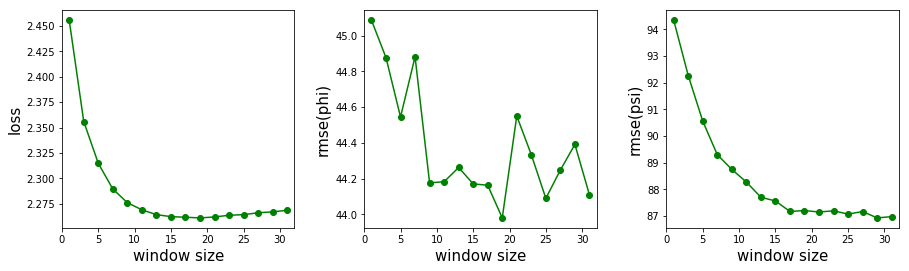

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(15, 4)

xyc = np.array(scores)[5:]

# set style
for col in (0,1,2):
    ax[col].set_xlim([0,32])
    ax[col].set_xlabel("window size", fontsize=15)

ax[0].set_ylabel("loss", fontsize=15)
ax[0].plot(range(1,32,2), xyc[:,2], linestyle='-', marker='o', color='g')

ax[1].set_ylabel("rmse(phi)", fontsize=15)
ax[1].plot(range(1,32,2), xyc[:,0], linestyle='-', marker='o', color='g')

ax[2].set_ylabel("rmse(psi)", fontsize=15)
ax[2].plot(range(1,32,2), xyc[:,1], linestyle='-', marker='o', color='g')

plt.subplots_adjust(wspace = 0.3)

plt.show()

## Regularization strength tuning

## Number of clusters